In [1]:
import sys, os, fnmatch, datetime, subprocess, imp
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
b6_cas9_match = pd.read_csv('b6_cas9_match.csv')
b6_match_all = pd.read_csv('b6_match_all.csv')
b6_match_all = b6_match_all.drop('id', axis=1).rename(columns={'real_id':'id'})

In [3]:
b6_cas9_dict = pd.Series(b6_cas9_match.id.values, index = b6_cas9_match.umi).to_dict()
b6_match_dict = pd.Series(b6_match_all.id.values, index = b6_match_all.umi).to_dict()

In [38]:
def vote(b6_match):
    percent_group = pd.DataFrame(b6_match.groupby('umi')['slice_type'].value_counts(normalize=True)).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('umi')
    b_50 = percent_group.loc[(percent_group.percent >= 0.5)&(percent_group.slice_type == 'b')]
    b_50_dict = pd.Series(b_50.slice_type.values, index = b_50.umi).to_dict()
    b6_removed_reads = b6_match.drop_duplicates(['umi', 'id'])
    print(b6_match.groupby(['umi','id']).ngroups == b6_removed_reads.shape[0])
    b6_removed_reads['b_50'] = b6_removed_reads.umi.apply(lambda umi: 1 if umi in b_50_dict else 0)
    b_percentage = pd.DataFrame(b6_removed_reads.groupby('id')['b_50'].mean()).reset_index('id')
    return b_percentage

In [36]:
def plot_ignore_read(b6_match):
    """
    should print true and also id count
    """
    b_percentage = vote(b6_match)
    f = plt.figure()
    f.set_size_inches(20,10)
    plt.scatter(b_percentage.id.values, b_percentage.b_50.values)

In [7]:
def read_count(b6_match):
    b6_ids = b6_match.id.unique()
    all_scores = b6_match.groupby('id')['slice_type'].value_counts(normalize=True).rename(columns = {'slice_type':'percent'}).reset_index('slice_type').reset_index('id').rename(columns = {0:'percent'})
    b_scores = all_scores.loc[lambda x: x.slice_type == 'b']
    b_score_dict = pd.Series(b_scores.slice_type.values, index = b_scores.id).to_dict()
    for x in b6_ids:
        if x not in b_score_dict:
            b_scores = b_scores.append({'id':x, 'slice_type':'b', 'percent': 0.0}, ignore_index=True)
    return b_scores

In [8]:
def plot_read(b6_match):
    b_scores = read_count(b6_match)
    f = plt.figure()
    f.set_size_inches(20,10)
    plt.scatter(b_scores.id.values, b_scores.percent.values)

In [42]:
def corr_plot(b6_match, name):
    plot_1 = vote(b6_match).sort_values('id')
    plot_2 = read_count(b6_match).sort_values('id')
    f = plt.figure()
    f.suptitle('Correlation between two ways of calculating normal splicing percentage: vote per UMI vs all reads per gRNA - '+name)
    f.set_size_inches(20,10)
    plt.scatter(plot_1.b_50.values, plot_2.percent.values)
    plt.xlabel('b splice percentage (vote per UMI)')
    plt.ylabel('b splice percentage (all reads per gRNA)')

### Double filtering of b7, b3 cas9, b6 - scatterplot

Assumes read count does not accurately portray diversity of certain outcomes --> normalizes

group by UMI --> for each UMI, calculate percentage of reads that are of b type --> create a dictionary of only UMIs that are of 'b type'

True


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


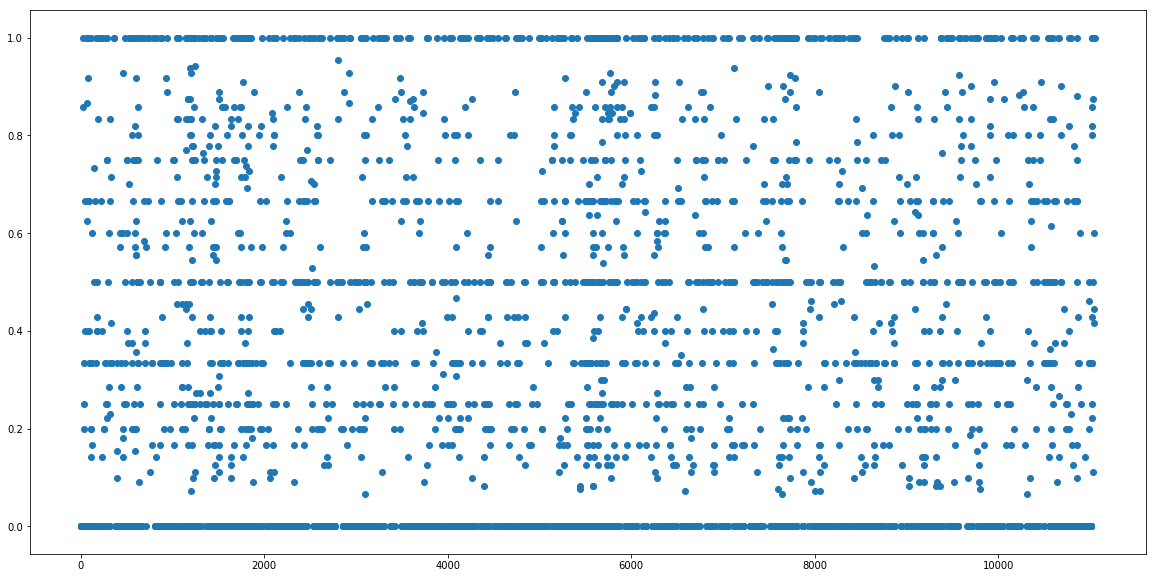

In [39]:
plot_ignore_read(b6_cas9_match)

## Plot 2

Double filtering of b7, b3 cas9, b6 
    - Each point - grna
    - Height = fraction of UMIs of b type (score on each UMI is the count of b splice type in all reads of the UMI: add up score for all UMIs of one gRNA, 
    and plot percentage of b scores over all reads of all UMIs) 
    - Assumes that read count is relevant → good indicator of an individual molecule 


Essentially: count up b scores of all reads of a gRNA, and divide by total number of reads for that gRNA 

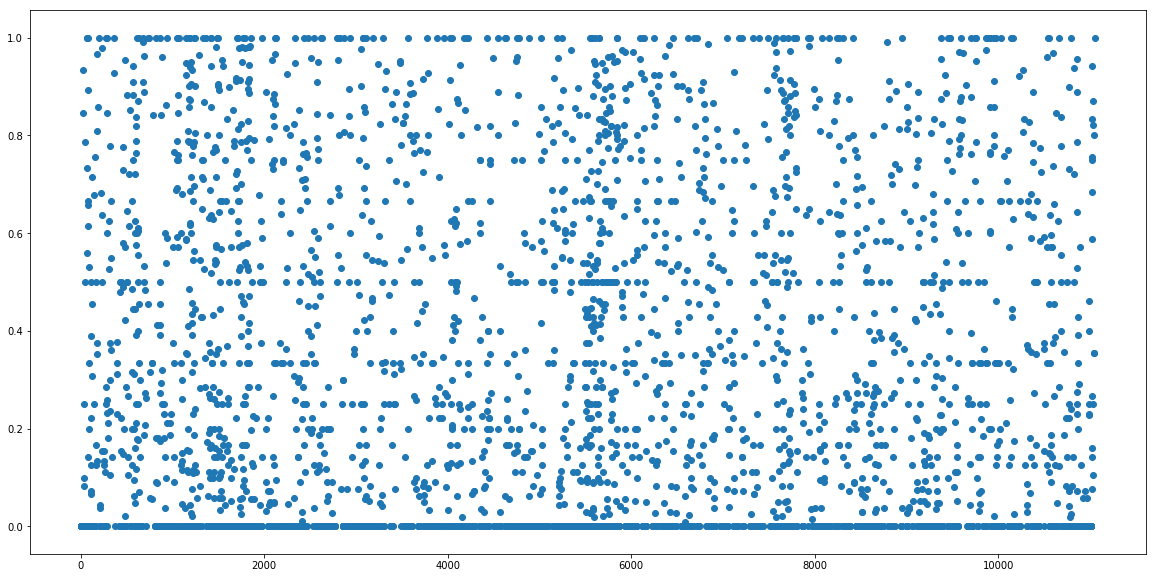

In [10]:
plot_read(b6_cas9_match)

True


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


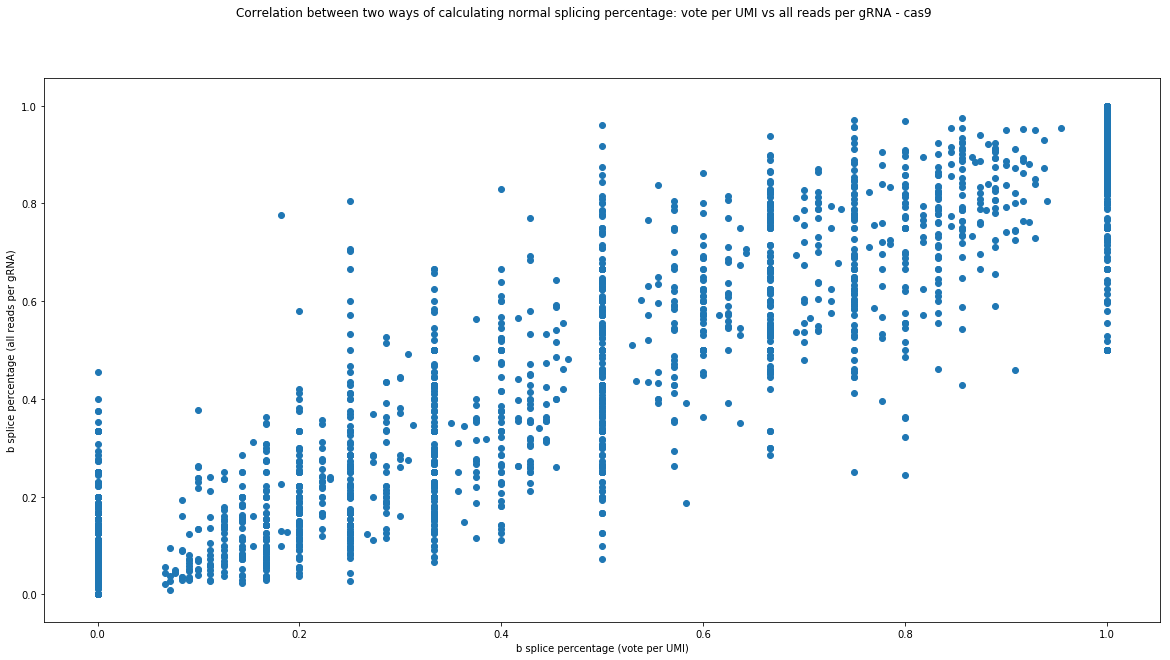

In [43]:
corr_plot(b6_cas9_match, 'cas9')

# b6 --> all splice types, no cas9

## Plot 1:

In [117]:
len(b_percentage.id.values)

3581

True
3812


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


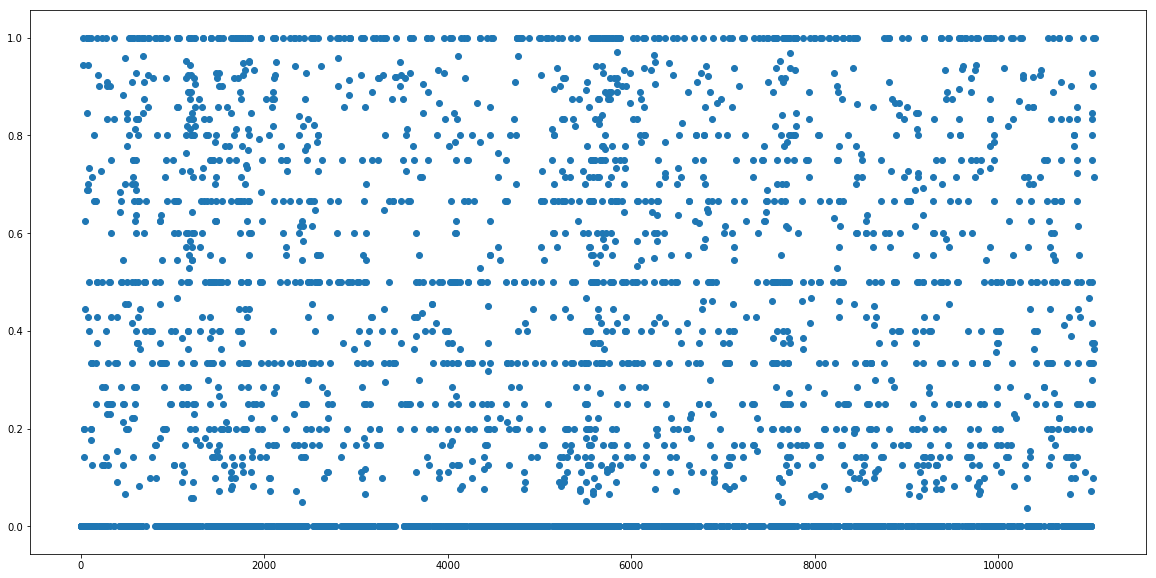

In [138]:
plot_ignore_read(b6_match_all)

## Plot 2:

3812


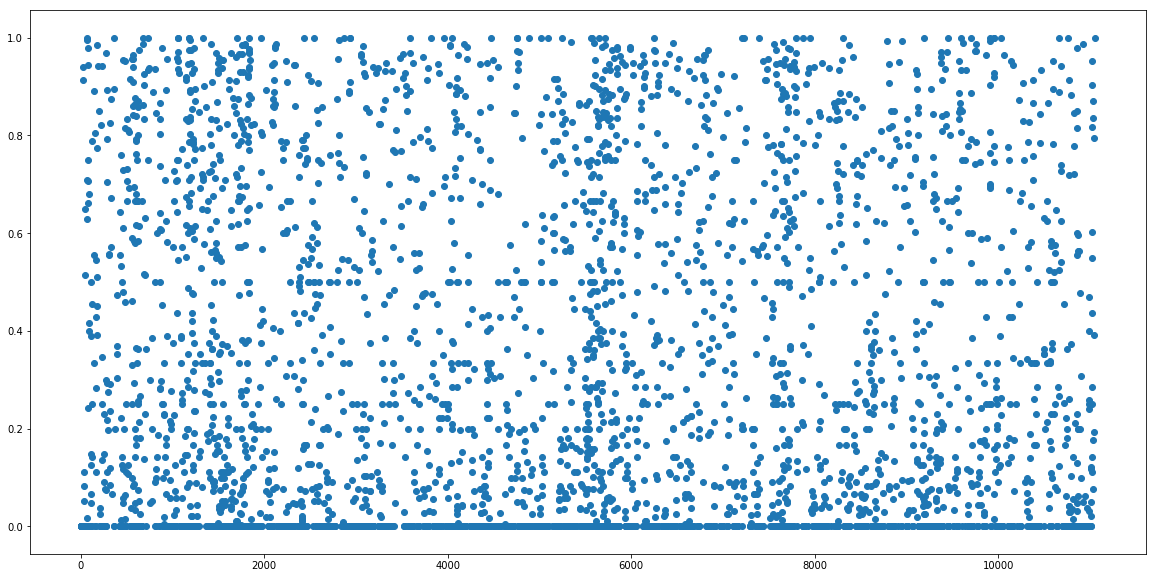

In [137]:
plot_read(b6_match_all)

## Plot 3:

True


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


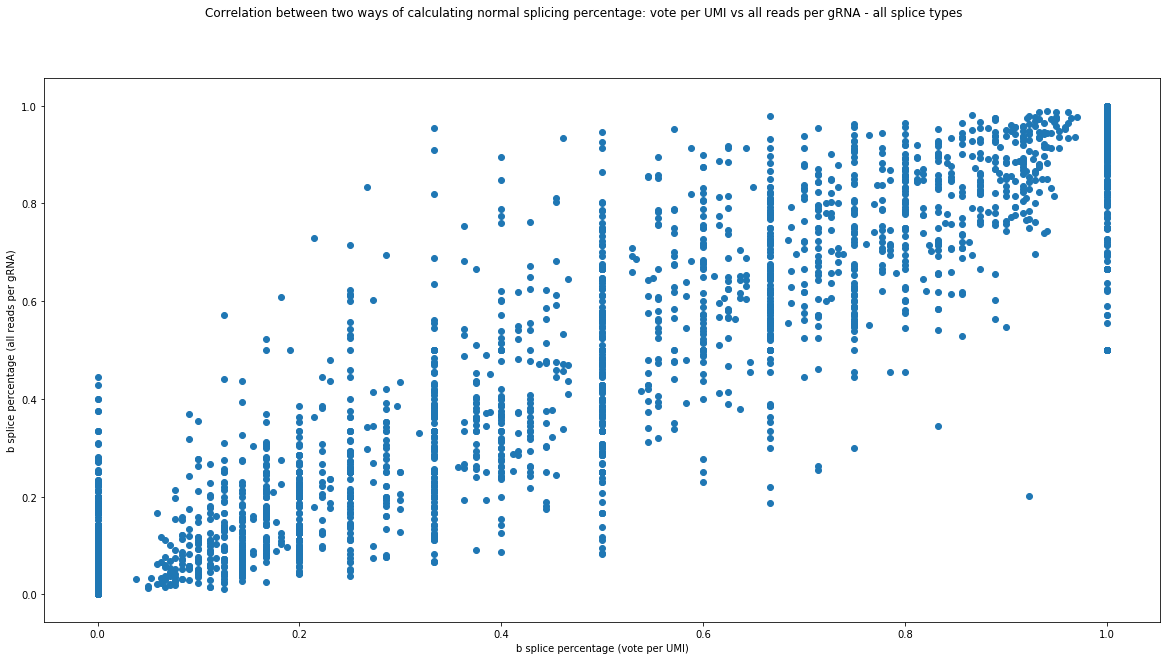

In [44]:
corr_plot(b6_match_all, 'all splice types')

# b6 --> unique acceptor/gRNA with cas9

In [45]:
unique_targets = pd.read_csv('unique_targets.csv')
uniq_target_dict = pd.Series(unique_targets.target_site.values, index = unique_targets.id).to_dict()

In [46]:
b3_cas9 = pd.read_csv('b3_cas9.csv')

In [47]:
b3_cas9['unique_target'] = b3_cas9.id.apply(lambda x: True if x in uniq_target_dict else False)
b3_cas9_unique = b3_cas9.loc[lambda x: x.unique_target == True]

In [48]:
genotype_count = b3_cas9_unique.groupby('umi')['id'].nunique().reset_index('umi').rename(columns = {'id':'id_count'})
genotype_uniq_umi = genotype_count.loc[genotype_count.id_count==1]
genotype_unique = b3_cas9_unique[b3_cas9_unique.umi.isin(genotype_uniq_umi['umi'])]

In [49]:
genotype_unique.id.nunique()

826

In [50]:
genotype_unique_dict = pd.Series(genotype_unique.id.values, index = genotype_unique.umi).to_dict()

In [82]:
b6 = pd.read_csv('b6.csv', dtype={'id':'Int64'})

In [83]:
b6['unique_target'] = b6.umi.apply(lambda x: True if x in genotype_unique_dict else False)
b6_unique_match = b6.loc[lambda x: x.unique_target == True]

In [84]:
b6_unique_match['real_id'] = b6_unique_match.umi.apply(lambda x: genotype_unique_dict[x])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
b6_unique_match = b6_unique_match.drop('id', axis=1).rename(columns={'real_id':'id'})

In [97]:
b6_unique_match.id.nunique()

818

True


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


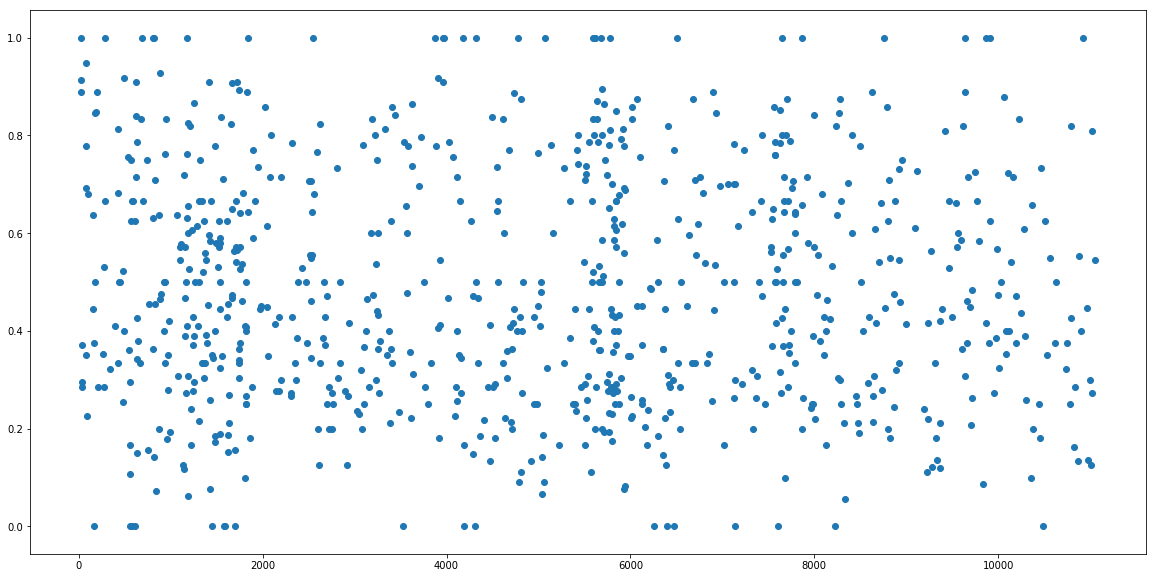

In [93]:
plot_ignore_read(b6_unique_match)

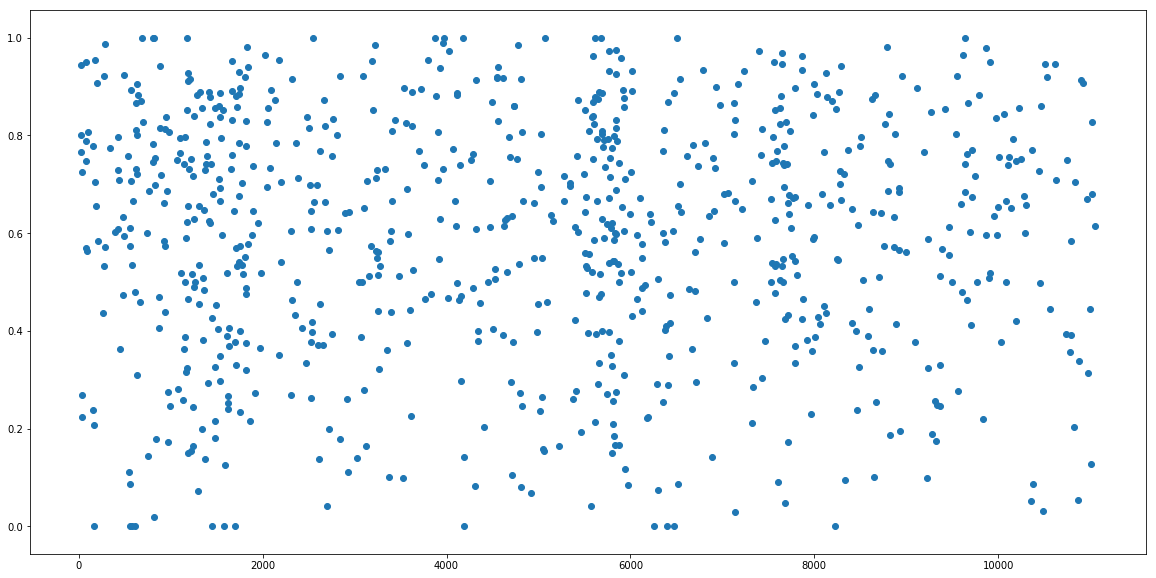

In [94]:
plot_read(b6_unique_match)

True


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


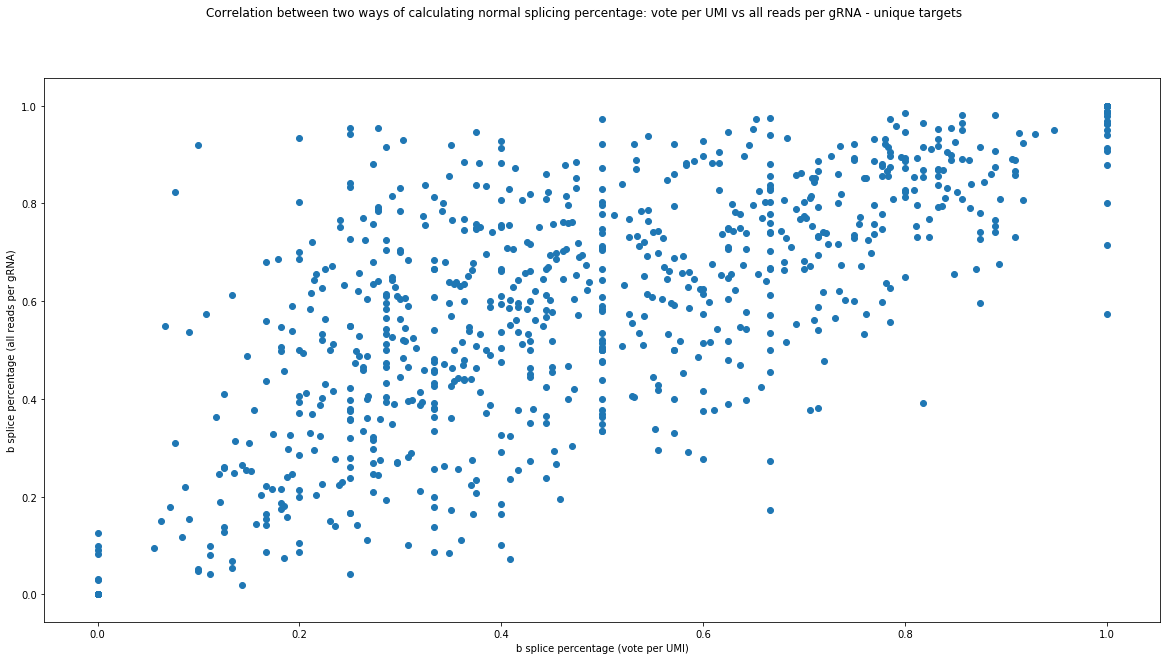

In [96]:
corr_plot(b6_unique_match, "unique targets")